<a href="https://colab.research.google.com/github/nvdraper04/nvdraper04.github.io/blob/main/Social_Media_Prediction_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install pandas scikit-learn streamlit

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from google.colab import auth
import gspread
from google.auth import default

# Authenticate to Google
auth.authenticate_user()

# Get the credentials and create an authorized client.
creds, _ = default()
gc = gspread.authorize(creds)

# Open the spreadsheet by its title or URL
spreadsheet = gc.open('Combined Social Media Data')

# Select the first worksheet
worksheet = spreadsheet.sheet1

# Get all values from the worksheet as a list of lists
data = worksheet.get_all_values()

# Convert the list of lists to a pandas DataFrame
import pandas as pd
df = pd.DataFrame(data[1:], columns=data[0])

# Display the first few rows of the DataFrame
display(df.tail())

,Description,Permalink,Platform,Post_type,Publish_Date,Time,Duration_(sec),Impressions,Reach,Likes,Shares,Plays,Comments,Saves,Genres,Content_type
2048,Results are in! 🔥 Top 5 #ANIME poll winners ar...,https://www.tiktok.com/@cooledtured/video/7490...,TikTok,TikTok_video,4/6/2025,14:51:00,,,,0,0,9,0,0,,
2049,"Happy birthday to Darkness herself, Dustiness ...",https://www.tiktok.com/@cooledtured/video/7488...,TikTok,TikTok_video,4/6/2025,17:00:00,,,,61,3,940,2,5,,
2050,Happy birthday to the Queen of the Fairies her...,https://www.tiktok.com/@cooledtured/video/7488...,TikTok,TikTok_video,4/7/2025,17:00:00,,,,63,0,1031,1,4,,
2051,Results are in! 🔥 Top 5 #GAMES poll winners ar...,https://www.tiktok.com/@cooledtured/video/7490...,TikTok,TikTok_video,4/7/2025,21:11:00,,,,3,0,147,0,0,,
2052,Happy birthday to the little sister heroine he...,https://www.tiktok.com/@cooledtured/video/7488...,TikTok,TikTok_video,4/8/2025,17:00:00,,,,0,0,1,0,0,,


In [2]:
# Identify columns with missing values
#print(df.isnull().sum())

# Convert specified columns to numeric, coercing errors to NaN
numerical_cols_to_convert = ['Duration_(sec)', 'Impressions', 'Reach', 'Plays', 'Saves', 'Likes', 'Shares', 'Comments']
for col in numerical_cols_to_convert:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Set 'Duration (sec)' to 0 for rows where 'Platform' is 'IG image'
df.loc[df["Platform"] == "IG image", "Duration_(sec)"] = 0
df.loc[df["Platform"] == "IG image", "Plays"] = 0

# Fill missing numerical values with the mean
numerical_cols_with_missing = ['Duration_(sec)', 'Impressions', 'Reach', 'Plays', 'Saves', 'Likes', 'Shares', 'Comments']
for col in numerical_cols_with_missing:
    df[col] = df[col].fillna(df[col].mean())


# Fill missing 'Description' values with an empty string
df['Description'] = df['Description'].fillna("")

# Fill missing 'Genres' and 'Content_type' with a placeholder
df['Genres'] = df['Genres'].fillna('Unknown')
df['Content_type'] = df['Content_type'].fillna('Unknown')


# Convert 'Publish_Date' and 'Time' to datetime objects
df["Publish_Date"] = pd.to_datetime(df["Publish_Date"].astype(str), errors='coerce')
df["Time"] = pd.to_datetime(df["Time"].astype(str), errors='coerce')
df["Time"] = df["Time"].fillna(df["Time"].mean())
df['Year'] = df['Publish_Date'].dt.year
df['Month'] = df['Publish_Date'].dt.month
df['Day_of_Week'] = df['Publish_Date'].dt.dayofweek # Monday=0, Sunday=6
df['Hour'] = pd.to_datetime(df['Time'].astype(str)).dt.hour
#df['Publish_Date'] = datetime.datetime.strptime(df['Publish_Date'], "%Y-%m-%d %H:%M:%S")
#print(df['Publish_Date'].hour)

#print(df['Hour'])
#print(df["Day_of_Week"])

# Print the dtypes of the numerical columns after conversion
#print(df[numerical_cols_to_convert].dtypes)

print(df.isnull().sum())

Description       0
Permalink         0
Platform          0
Post_type         0
Publish_Date      0
Time              0
Duration_(sec)    0
Impressions       0
Reach             0
Likes             0
Shares            0
Plays             0
Comments          0
Saves             0
Genres            0
Content_type      0
Year              0
Month             0
Day_of_Week       0
Hour              0
dtype: int64


/tmp/ipython-input-4018871947.py:29: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Time"] = pd.to_datetime(df["Time"].astype(str), errors='coerce')


In [ ]:
ave_ytplays = df[df["Post_type"] == "YT_video"]["Plays"].mean()
print(ave_ytplays)

ave_igplays = df[df["Post_type"] == "IG_reel"]["Plays"].mean()
print(ave_igplays)

238.4142259414226
283.16441069873184


In [3]:
from sklearn import preprocessing
#categorical_features = ["Platform", "Post_type", "Genres", "Content_type", "Hour", "Month", "Day_of_Week"] # with genre, content
#categorical_features = ["Platform", "Post_type", "Hour","Month", "Day_of_Week"] # without genre, content
categorical_features = ["Post_type", "Publish_Date", "Time"]
encoder = preprocessing.OneHotEncoder(handle_unknown='ignore')
one_hot_features = encoder.fit_transform(df[categorical_features])
one_hot_names = encoder.get_feature_names_out()
#print("Type of one_hot_columns is:",type(one_hot_features))
one_hot_df = pd.DataFrame.sparse.from_spmatrix(one_hot_features)
one_hot_df.columns = one_hot_names # Now we can see the actual meaning of the one-hot feature in the DataFrame
#one_hot_df.head()
#print(df.isnull().sum())

In [4]:
import re
from sklearn.feature_extraction.text import CountVectorizer
import scipy
import numpy as np
from sklearn.model_selection import train_test_split

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    return text

#df['clean_caption'] = df['Description'].apply(clean_text)

# Apply TF-IDF vectorization
tfidf = TfidfVectorizer(max_features=1000)
tfidf_matrix = tfidf.fit_transform(df['Description'])

#numerical_feature_names = ["Reach", "Plays", "Shares", "Saves", "Comments", "Duration_(sec)", "Hour", "Month", "Day_of_Week"] # Make Year, Month, and day categorial
#numerical_feature_names = ['Duration_(sec)', 'Plays', 'Comments', 'Saves', 'Day_of_Week']
#numerical_feature_names = ['Duration_(sec)', 'Plays', 'Comments', 'Saves']
numerical_feature_names = ['Plays', 'Comments', 'Saves']
#numerical_feature_names = ['Duration_(sec)', 'Shares', 'Plays', 'Comments', 'Saves', 'Hour', 'Month', 'Day_of_Week']
map_numerical_feature_names = ["Likes", "Reach", "Plays", "Shares", "Saves", "Comments", "Duration_(sec)", "Hour", "Month", "Day_of_Week"] # for correlation map
#numerical_feature_names = ["Duration (sec)", "Reach","Plays"] # Make Year, Month, and day categorial
#numerical_feature_names = ["Duration (sec)"]
#numerical_feature_names = ["Duration (sec)", "Reach", "Plays", "Saves"] # Comments has the best accuracy so far
#numerical_feature_names = ["Reach", "Plays", "Comments", "Duration (sec)"]
numerical_features = df[numerical_feature_names]
map_numerical_features = df[map_numerical_feature_names]
# Print dtypes to identify the problematic column
#print(numerical_features.dtypes)

features = scipy.sparse.hstack((numerical_features, one_hot_features),format='csr')
#features_without_numerical = scipy.sparse.csr_matrix(one_hot_features)
features_with_text = scipy.sparse.hstack((features, tfidf_matrix),format='csr')
#features_with_text_without_numerical = scipy.sparse.hstack((features_without_numerical, tfidf_matrix),format='csr')
text_without_categoraial = scipy.sparse.hstack((numerical_features, tfidf_matrix),format='csr')
#print(feature_with_text)
#all_feature_names = np.hstack((numerical_feature_names,one_hot_names))
#all_feature_names = np.hstack((numerical_feature_names, tfidf_matrix))
#print(all_feature_names
#target_column = ['Likes']
#target = df[target_column].values
target = df['Likes']
#print(target)

# Perform train and test split of data
rand_seed = 52 # For other models we will use the same random seed, so that we're always using the same train-test split
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2, random_state=rand_seed) # 80 / 20 split

features_train_with_text, features_test_with_text, target_train, target_test = train_test_split(
    features_with_text, target, test_size=0.2, random_state=rand_seed)

#features_train_with_text_without_numerical, features_test_with_text_without_numerical, target_train, target_test = train_test_split(
    #features_with_text_without_numerical, target, test_size=0.2, random_state=rand_seed)

text_train, text_test, target_train, target_test = train_test_split(
    text_without_categoraial, target, test_size=0.2, random_state=rand_seed)

# Matrix for numerical values


In [ ]:
matrix = map_numerical_features.corr(method = "spearman").round(2)
matrix.style.background_gradient(cmap='coolwarm')

,Likes,Reach,Plays,Shares,Saves,Comments,Duration_(sec),Hour,Month,Day_of_Week
Likes,1.000000,0.160000,0.600000,0.360000,-0.040000,0.370000,0.030000,0.140000,-0.070000,0.060000
Reach,0.160000,1.000000,0.210000,0.230000,0.320000,0.050000,0.400000,0.210000,-0.110000,0.030000
Plays,0.600000,0.210000,1.000000,0.320000,-0.240000,0.280000,-0.080000,0.160000,-0.050000,0.060000
Shares,0.360000,0.230000,0.320000,1.000000,0.010000,0.230000,0.170000,0.060000,-0.040000,0.070000
Saves,-0.040000,0.320000,-0.240000,0.010000,1.000000,0.070000,0.320000,0.150000,-0.100000,0.020000
Comments,0.370000,0.050000,0.280000,0.230000,0.070000,1.000000,0.010000,0.050000,-0.110000,0.030000
Duration_(sec),0.030000,0.400000,-0.080000,0.170000,0.320000,0.010000,1.000000,0.190000,-0.030000,0.020000
Hour,0.140000,0.210000,0.160000,0.060000,0.150000,0.050000,0.190000,1.000000,-0.020000,-0.020000
Month,-0.070000,-0.110000,-0.050000,-0.040000,-0.100000,-0.110000,-0.030000,-0.020000,1.000000,-0.120000
Day_of_Week,0.060000,0.030000,0.060000,0.070000,0.020000,0.030000,0.020000,-0.020000,-0.120000,1.000000


In [ ]:
# Get unique post types
unique_post_types = df['Post_type'].unique()

# Calculate and display correlation matrix for each post type
for post_type in unique_post_types:
    print(f"\n--- Correlation Matrix for Post Type: {post_type} ---")
    # Filter DataFrame for the current post type
    df_filtered = df[df['Post_type'] == post_type].copy() # Use .copy() to avoid SettingWithCopyWarning

    # Define a set of relevant numerical columns for each post type
    if post_type == "IG_image":
        numerical_cols = ['Impressions', 'Reach', 'Likes', 'Saves', 'Comments', 'Year', 'Month', 'Day_of_Week', 'Hour']
    elif post_type == "IG_reel":
        numerical_cols = ['Duration_(sec)', 'Impressions', 'Reach', 'Likes', 'Shares', 'Plays', 'Comments', 'Saves', 'Year', 'Month', 'Day_of_Week', 'Hour']
    elif post_type == "YT_video":
        numerical_cols = ['Duration_(sec)', 'Impressions', 'Reach', 'Likes', 'Shares', 'Plays', 'Comments', 'Saves', 'Year', 'Month', 'Day_of_Week', 'Hour']
    elif post_type == "IG_carousel":
         numerical_cols = ['Impressions', 'Reach', 'Likes', 'Saves', 'Comments', 'Year', 'Month', 'Day_of_Week', 'Hour']
    else:
        # Default to all numerical columns if post type is unexpected
        numerical_cols = df_filtered.select_dtypes(include=np.number).columns


    # Filter the DataFrame to include only the relevant numerical columns
    df_filtered_numerical = df_filtered[numerical_cols]

    # Drop columns with all NaN values before calculating correlation
    df_filtered_numerical = df_filtered_numerical.dropna(axis=1, how='all')

    # Calculate the correlation matrix
    if not df_filtered_numerical.empty and len(df_filtered_numerical.columns) > 1:
        correlation_matrix = df_filtered_numerical.corr(method="spearman").round(2)

        # Display the correlation matrix
        display(correlation_matrix.style.background_gradient(cmap='coolwarm'))
    else:
        print("Not enough numerical data to calculate correlation matrix for this post type.")


--- Correlation Matrix for Post Type: IG_image ---


,Impressions,Reach,Likes,Saves,Comments,Year,Month,Day_of_Week,Hour
Impressions,1.000000,0.930000,0.050000,0.050000,-0.100000,-0.020000,-0.070000,0.030000,0.000000
Reach,0.930000,1.000000,0.080000,0.030000,-0.100000,-0.170000,-0.000000,0.030000,-0.040000
Likes,0.050000,0.080000,1.000000,0.310000,0.230000,-0.500000,0.160000,0.080000,-0.070000
Saves,0.050000,0.030000,0.310000,1.000000,0.070000,-0.100000,-0.090000,0.120000,-0.010000
Comments,-0.100000,-0.100000,0.230000,0.070000,1.000000,0.070000,-0.150000,0.020000,-0.230000
Year,-0.020000,-0.170000,-0.500000,-0.100000,0.070000,1.000000,-0.610000,-0.050000,-0.020000
Month,-0.070000,-0.000000,0.160000,-0.090000,-0.150000,-0.610000,1.000000,-0.060000,0.110000
Day_of_Week,0.030000,0.030000,0.080000,0.120000,0.020000,-0.050000,-0.060000,1.000000,0.010000
Hour,0.000000,-0.040000,-0.070000,-0.010000,-0.230000,-0.020000,0.110000,0.010000,1.000000



--- Correlation Matrix for Post Type: IG_reel ---


,Duration_(sec),Impressions,Reach,Likes,Shares,Plays,Comments,Saves,Year,Month,Day_of_Week,Hour
Duration_(sec),1.000000,-0.040000,-0.020000,0.010000,-0.000000,-0.100000,-0.020000,0.120000,0.190000,0.160000,0.080000,0.140000
Impressions,-0.040000,1.000000,0.920000,0.210000,0.350000,0.690000,0.090000,-0.070000,0.430000,-0.170000,0.070000,0.020000
Reach,-0.020000,0.920000,1.000000,0.290000,0.410000,0.720000,0.140000,-0.060000,0.480000,-0.220000,0.080000,0.080000
Likes,0.010000,0.210000,0.290000,1.000000,0.330000,0.450000,0.320000,0.310000,-0.190000,-0.190000,0.070000,0.190000
Shares,-0.000000,0.350000,0.410000,0.330000,1.000000,0.390000,0.210000,0.070000,0.200000,-0.080000,0.130000,0.040000
Plays,-0.100000,0.690000,0.720000,0.450000,0.390000,1.000000,0.160000,-0.030000,0.280000,-0.160000,0.070000,0.130000
Comments,-0.020000,0.090000,0.140000,0.320000,0.210000,0.160000,1.000000,0.280000,0.000000,-0.180000,0.050000,0.120000
Saves,0.120000,-0.070000,-0.060000,0.310000,0.070000,-0.030000,0.280000,1.000000,-0.200000,-0.060000,0.050000,0.150000
Year,0.190000,0.430000,0.480000,-0.190000,0.200000,0.280000,0.000000,-0.200000,1.000000,-0.340000,0.090000,-0.050000
Month,0.160000,-0.170000,-0.220000,-0.190000,-0.080000,-0.160000,-0.180000,-0.060000,-0.340000,1.000000,-0.180000,-0.060000



--- Correlation Matrix for Post Type: IG_carousel ---


,Impressions,Reach,Likes,Saves,Comments,Year,Month,Day_of_Week,Hour
Impressions,1.000000,0.970000,0.420000,0.140000,0.140000,-0.450000,0.140000,0.370000,-0.070000
Reach,0.970000,1.000000,0.400000,0.170000,0.170000,-0.460000,0.120000,0.330000,-0.110000
Likes,0.420000,0.400000,1.000000,0.190000,0.190000,-0.560000,0.450000,-0.000000,0.130000
Saves,0.140000,0.170000,0.190000,1.000000,1.000000,0.060000,0.010000,-0.210000,0.240000
Comments,0.140000,0.170000,0.190000,1.000000,1.000000,0.060000,0.010000,-0.210000,0.240000
Year,-0.450000,-0.460000,-0.560000,0.060000,0.060000,1.000000,-0.310000,-0.000000,0.030000
Month,0.140000,0.120000,0.450000,0.010000,0.010000,-0.310000,1.000000,-0.010000,0.480000
Day_of_Week,0.370000,0.330000,-0.000000,-0.210000,-0.210000,-0.000000,-0.010000,1.000000,-0.190000
Hour,-0.070000,-0.110000,0.130000,0.240000,0.240000,0.030000,0.480000,-0.190000,1.000000



--- Correlation Matrix for Post Type: YT_video ---


/usr/local/lib/python3.12/dist-packages/pandas/io/formats/style.py:3807: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/usr/local/lib/python3.12/dist-packages/pandas/io/formats/style.py:3808: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,Duration_(sec),Impressions,Reach,Likes,Shares,Plays,Comments,Saves,Year,Month,Day_of_Week,Hour
Duration_(sec),1.000000,nan,0.070000,-0.020000,-0.070000,0.000000,0.060000,nan,0.280000,0.090000,0.090000,0.170000
Impressions,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Reach,0.070000,nan,1.000000,0.240000,0.170000,0.430000,0.140000,nan,0.170000,-0.090000,-0.010000,0.110000
Likes,-0.020000,nan,0.240000,1.000000,0.320000,0.700000,0.360000,nan,0.460000,-0.360000,0.070000,0.140000
Shares,-0.070000,nan,0.170000,0.320000,1.000000,0.290000,0.260000,nan,0.150000,-0.090000,0.080000,-0.000000
Plays,0.000000,nan,0.430000,0.700000,0.290000,1.000000,0.340000,nan,0.580000,-0.310000,0.060000,0.240000
Comments,0.060000,nan,0.140000,0.360000,0.260000,0.340000,1.000000,nan,0.250000,-0.100000,0.040000,0.080000
Saves,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Year,0.280000,nan,0.170000,0.460000,0.150000,0.580000,0.250000,nan,1.000000,-0.500000,0.170000,0.160000
Month,0.090000,nan,-0.090000,-0.360000,-0.090000,-0.310000,-0.100000,nan,-0.500000,1.000000,-0.140000,-0.040000



--- Correlation Matrix for Post Type: TikTok_video ---


/usr/local/lib/python3.12/dist-packages/pandas/io/formats/style.py:3807: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/usr/local/lib/python3.12/dist-packages/pandas/io/formats/style.py:3808: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,Duration_(sec),Impressions,Reach,Likes,Shares,Plays,Comments,Saves,Year,Month,Day_of_Week,Hour
Duration_(sec),nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Impressions,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Reach,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Likes,nan,nan,nan,1.000000,0.440000,0.850000,0.500000,0.720000,0.130000,-0.020000,-0.000000,0.160000
Shares,nan,nan,nan,0.440000,1.000000,0.470000,0.310000,0.460000,-0.010000,0.050000,0.100000,-0.030000
Plays,nan,nan,nan,0.850000,0.470000,1.000000,0.480000,0.600000,0.040000,0.080000,0.020000,0.080000
Comments,nan,nan,nan,0.500000,0.310000,0.480000,1.000000,0.400000,0.070000,-0.010000,-0.030000,0.080000
Saves,nan,nan,nan,0.720000,0.460000,0.600000,0.400000,1.000000,-0.010000,0.110000,-0.020000,0.070000
Year,nan,nan,nan,0.130000,-0.010000,0.040000,0.070000,-0.010000,1.000000,-0.840000,0.100000,0.200000
Month,nan,nan,nan,-0.020000,0.050000,0.080000,-0.010000,0.110000,-0.840000,1.000000,-0.020000,-0.030000


# Models for Likes

# Random Forest

In [8]:
# Initializing the Random Forest Regression model with 100 decision trees
model_no_text = RandomForestRegressor(n_estimators = 500, random_state = 12)
model_with_text = RandomForestRegressor(n_estimators = 500, random_state = 12)
#model_with_text_without_categorial = RandomForestRegressor(n_estimators = 100, random_state = 12)
#model_with_text_without_numerical = RandomForestRegressor(n_estimators = 100, random_state = 12)

#target_train = target_train.ravel()
# Fitting the Random Forest Regression model to the data
model_no_text.fit(features_train, target_train)
model_with_text.fit(features_train_with_text, target_train)
#model_with_text_without_categorial.fit(text_train, target_train)
#model_with_text_without_numerical.fit(features_train_with_text_without_numerical, target_train)

test_score_no_text = model_no_text.score(features_test,target_test)
test_score_with_text = model_with_text.score(features_test_with_text,target_test)
#test_score_with_text_without_categorial = model_with_text_without_categorial.score(text_test,target_test)
#test_score_with_text_without_numerical = model_with_text_without_numerical.score(features_test_with_text_without_numerical,target_test)
print("Test score for Regression WITHOUT text features:", test_score_no_text)
print("Test score for Regression WITH text features:", test_score_with_text)
#print("Test score for Regression WITH text features and WITHOUT categorial features:", test_score_with_text_without_categorial)
#print("Test score for Regression WITH text features and WITHOUT numerical features:", test_score_with_text_without_numerical)

#Test score for Regression WITHOUT text features: 0.6415016654177034
#Test score for Regression WITH text features: 0.4289182792855367
#Test score for Regression WITH text features and WITHOUT categorial features: 0.5014939931350306
#numerical_feature_names = ["Duration (sec)", "Reach", "Shares", "Plays", "Comments", "Saves"]
#categorical_features = ["Platform", "Post type", "Hour","Month", "Day_of_Week"]

# Test score:  0.41340728204899235
#numerical_feature_names = ["Duration (sec)", "Reach", "Shares", "Plays", "Comments", "Saves"]
#categorical_features = ["Post type", "Hour","Day_of_Week"]

# Test score:  0.31786629338258754
#numerical_feature_names = ["Duration (sec)", "Reach","Plays", "Comments", "Saves"]
#categorical_features = ["Post type", "Hour","Day_of_Week"]

# Test score:  0.4692266054694729
#numerical_feature_names = ["Duration (sec)", "Reach","Plays", "Comments"]
#categorical_features = ["Post type", "Hour","Day_of_Week"]

# Test score:  0.13664760988282265
#numerical_feature_names = ["Duration (sec)", "Reach","Plays"]
#categorical_features = ["Post type", "Hour","Day_of_Week"]

#Test score for Regression WITHOUT text features: 0.6777442912340723
#Test score for Regression WITH text features: 0.46639578579668817
#Test score for Regression WITH text features and WITHOUT categorial features: 0.5014939931350306
#numerical_feature_names = ["Duration (sec)", "Reach", "Shares", "Plays", "Comments", "Saves"]
#categorical_features = ["Post type"]

#Test score for Regression WITHOUT text features: 0.6216716963182718
#Test score for Regression WITH text features: 0.4434153481108125
#Test score for Regression WITH text features and WITHOUT categorial features: 0.468742361679916
#numerical_feature_names = ["Duration (sec)", "Reach", "Shares", "Plays", "Comments", "Saves", "Hour", "Month", "Day_of_Week"]
#categorical_features = ["Post type"]

#numerical_feature_names = ["Duration (sec)", "Reach","Plays", "Hour", "Month", "Day_of_Week"]
#categorical_features = ["Post type"]

Test score for Regression WITHOUT text features: 0.8002938097616488
Test score for Regression WITH text features: 0.8317631210376015


# Ridge Regression

In [ ]:
from sklearn import linear_model
ridge_fit_without_text = linear_model.RidgeCV(cv=5)
ridge_fit_without_text.fit(features_train, target_train)
ridge_fit_with_text = linear_model.RidgeCV(cv=5)
ridge_fit_with_text.fit(features_train_with_text, target_train)
ridge_fit_with_text_without_categorial = linear_model.RidgeCV(cv=5)
ridge_fit_with_text_without_categorial.fit(text_train, target_train)
#ridge_fit_with_text_without_numerical = linear_model.RidgeCV(cv=5)
#ridge_fit_with_text_without_numerical.fit(features_train_with_text_without_numerical, target_train)

ridge_test_score_no_text = ridge_fit_without_text.score(features_test,target_test)
ridge_test_score_with_text = ridge_fit_with_text.score(features_test_with_text,target_test)
ridge_test_score_with_text_without_categorial = ridge_fit_with_text_without_categorial.score(text_test,target_test)
#ridge_test_score_with_text_without_numerical = ridge_fit_with_text_without_numerical.score(features_test_with_text_without_numerical,target_test)
print("Test score for Regression WITHOUT text features:", ridge_test_score_no_text)
print("Test score for Regression WITH text features:", ridge_test_score_with_text)
print("Test score for Regression WITH text features and WITHOUT categorial features:", ridge_test_score_with_text_without_categorial)
#print("Test score for Regression WITH text features and WITHOUT numerical features:", ridge_test_score_with_text_without_numerical)

#Test score for Regression WITHOUT text features: 0.5246827767673727
#Test score for Regression WITH text features: 0.5247144734516249
#Test score for Regression WITH text features and WITHOUT categorial features: 0.5243313917018737
#numerical_feature_names = ["Duration (sec)", "Reach", "Shares", "Plays", "Comments", "Saves"]
#categorical_features = ["Platform", "Post type", "Hour","Month", "Day_of_Week"]

# Test score: 0.5245388099837138
#numerical_feature_names = ["Duration (sec)", "Reach", "Shares", "Plays", "Comments", "Saves"]
#categorical_features = ["Post type", "Hour","Day_of_Week"]

# Test score:   0.30391906307495986
#numerical_feature_names = ["Duration (sec)", "Reach","Plays", "Comments", "Saves"]
#categorical_features = ["Post type", "Hour","Day_of_Week"]

# Test score:   0.27690593675235753
#numerical_feature_names = ["Duration (sec)", "Reach", "Plays", "Comments"]
#categorical_features = ["Post type", "Hour","Day_of_Week"]

# Test score:  -0.5926238849131946
#numerical_feature_names = ["Duration (sec)", "Reach","Plays"]
#categorical_features = ["Post type", "Hour","Day_of_Week"]

#Test score for Regression WITHOUT text features: 0.5243499250961672
#Test score for Regression WITH text features: 0.5243862533345616
#Test score for Regression WITH text features and WITHOUT categorial features: 0.5243313917018737
#numerical_feature_names = ["Duration (sec)", "Reach", "Shares", "Plays", "Comments", "Saves"]
#categorical_features = ["Post type"]

#Test score for Regression WITHOUT text features: 0.5238700324693952
#Test score for Regression WITH text features: 0.5239170595588729
#Test score for Regression WITH text features and WITHOUT categorial features: 0.5238111708188067
#numerical_feature_names = ["Duration (sec)", "Reach", "Shares", "Plays", "Comments", "Saves", "Hour", "Month", "Day_of_Week"]
#categorical_features = ["Post type"]



Test score for Regression WITHOUT text features: 0.7253086285562013
Test score for Regression WITH text features: 0.7195203851429399
Test score for Regression WITH text features and WITHOUT categorial features: 0.6872256336825876


# XGBoost

In [ ]:
import xgboost as xgb

# Initialize and train XGBoost model without text features
xgb_model_no_text = xgb.XGBRegressor(objective='reg:squarederror', random_state=12)
xgb_model_no_text.fit(features_train, target_train)

# Initialize and train XGBoost model with text features
xgb_model_with_text = xgb.XGBRegressor(objective='reg:squarederror', random_state=12)
xgb_model_with_text.fit(features_train_with_text, target_train)

#Initialize and train XGBoost model with text features but without categorials
xgb_model_with_text_without_categorial = xgb.XGBRegressor(objective='reg:squarederror', random_state=12)
xgb_model_with_text_without_categorial.fit(text_train, target_train)

# Initialize and train XGBoost model with text features but without numericals
#xgb_model_with_text_without_numerical = xgb.XGBRegressor(objective='reg:squarederror', random_state=12)
#xgb_model_with_text_without_numerical.fit(features_train_with_text_without_numerical, target_train)

# Evaluate XGBoost model without text features
xgb_test_score_no_text = xgb_model_no_text.score(features_test, target_test)
print("Test score for XGBoost WITHOUT text features:", xgb_test_score_no_text)

# Evaluate XGBoost model with text features
xgb_test_score_with_text = xgb_model_with_text.score(features_test_with_text, target_test)
print("Test score for XGBoost WITH text features:", xgb_test_score_with_text)

Test score for XGBoost WITHOUT text features: 0.45611441135406494
Test score for XGBoost WITH text features: 0.436320960521698


# Models for Plays


In [6]:
#numerical_feature_names = ["Impressions", "Reach", "Shares", "Plays", "Comments", "Saves", "Year", "Month", "Day_of_Week", "Hour"] # Make Year, Month, and day categorial
#Plays_numerical_feature_names = ['Duration_(sec)', 'Likes', 'Comments', 'Saves', 'Day_of_Week'] # Make Year, Month, and day categorial
#Plays_numerical_feature_names = ['Duration_(sec)', 'Likes', 'Comments', 'Saves']
Plays_numerical_feature_names = ['Likes', 'Comments', 'Saves', 'Shares']
Plays_numerical_features = df[Plays_numerical_feature_names]

# Print dtypes to identify the problematic column
#print(Plays_numerical_features.dtypes)

Plays_features = scipy.sparse.hstack((Plays_numerical_features, one_hot_features),format='csr')
Plays_features_without_numerical = scipy.sparse.csr_matrix(one_hot_features)
Plays_features_with_text = scipy.sparse.hstack((Plays_features, tfidf_matrix),format='csr')
#Plays_features_with_text_without_numerical = scipy.sparse.hstack((features_without_numerical, tfidf_matrix),format='csr')
#print(feature_with_text)
Plays_all_feature_names = np.hstack((Plays_numerical_feature_names,one_hot_names))
#target_column = ['Likes']
#target = df[target_column].values
target_Plays = df['Plays']
#print(target_Plays)

# Perform train and test split of data
rand_seed = 52 # For other models we will use the same random seed, so that we're always using the same train-test split
Plays_features_train, Plays_features_test, Plays_target_train, Plays_target_test = train_test_split(
    Plays_features, target_Plays, test_size=0.2, random_state=rand_seed) # 80 / 20 split

Plays_features_train_with_text, Plays_features_test_with_text, Plays_target_train, Plays_target_test = train_test_split(
    Plays_features_with_text, target_Plays, test_size=0.2, random_state=rand_seed)

#features_train_with_text_without_numerical, features_test_with_text_without_numerical, target_train, target_test = train_test_split(
    #features_with_text_without_numerical, target, test_size=0.2, random_state=rand_seed)

In [9]:
# Initializing the Random Forest Regression model with 100 decision trees
Plays_model_no_text = RandomForestRegressor(n_estimators = 500, random_state = 12)
Plays_model_with_text = RandomForestRegressor(n_estimators = 500, random_state = 12)
#model_with_text_without_numerical = RandomForestRegressor(n_estimators = 100, random_state = 12)

#target_train = target_train.ravel()
# Fitting the Random Forest Regression model to the data
Plays_model_no_text.fit(Plays_features_train, Plays_target_train)
Plays_model_with_text.fit(Plays_features_train_with_text, Plays_target_train)
#model_with_text_without_numerical.fit(features_train_with_text_without_numerical, target_train)

Plays_test_score_no_text = Plays_model_no_text.score(Plays_features_test, Plays_target_test)
Plays_test_score_with_text = Plays_model_with_text.score(Plays_features_test_with_text, Plays_target_test)
#test_score_with_text_without_numerical = model_with_text_without_numerical.score(features_test_with_text_without_numerical,target_test)
print("Test score for Regression WITHOUT text features:", Plays_test_score_no_text)
print("Test score for Regression WITH text features:", Plays_test_score_with_text)
#print("Test score for Regression WITH text features and WITHOUT numerical features:", test_score_with_text_without_numerical)

Test score for Regression WITHOUT text features: 0.08819295318056697
Test score for Regression WITH text features: 0.11168261693247195


In [7]:
from sklearn import linear_model
Plays_ridge_fit_without_text = linear_model.RidgeCV(cv= 5)
Plays_ridge_fit_without_text.fit(Plays_features_train, Plays_target_train)
Plays_ridge_fit_with_text = linear_model.RidgeCV(cv= 5)
Plays_ridge_fit_with_text.fit(Plays_features_train_with_text, Plays_target_train)
#ridge_fit_with_text_without_numerical = linear_model.RidgeCV(cv=5)
#ridge_fit_with_text_without_numerical.fit(features_train_with_text_without_numerical, target_train)

Plays_ridge_test_score_no_text = Plays_ridge_fit_without_text.score(Plays_features_test, Plays_target_test)
Plays_ridge_test_score_with_text = Plays_ridge_fit_with_text.score(Plays_features_test_with_text, Plays_target_test)
#ridge_test_score_with_text_without_numerical = ridge_fit_with_text_without_numerical.score(features_test_with_text_without_numerical,target_test)
print("Test score for Regression WITHOUT text features:", Plays_ridge_test_score_no_text)
print("Test score for Regression WITH text features:", Plays_ridge_test_score_with_text)
#print("Test score for Regression WITH text features and WITHOUT numerical features:", ridge_test_score_with_text_without_numerical)

Test score for Regression WITHOUT text features: 0.6026022016757828
Test score for Regression WITH text features: 0.5941141503206527


In [ ]:
import xgboost as xgb

# Initialize and train XGBoost model without text features
Plays_xgb_model_no_text = xgb.XGBRegressor(objective='reg:squarederror', random_state=12)
Plays_xgb_model_no_text.fit(Plays_features_train, Plays_target_train)

# Initialize and train XGBoost model with text features
Plays_xgb_model_with_text = xgb.XGBRegressor(objective='reg:squarederror', random_state=12)
Plays_xgb_model_with_text.fit(Plays_features_train_with_text, Plays_target_train)

# Initialize and train XGBoost model with text features but without numericals
#xgb_model_with_text_without_numerical = xgb.XGBRegressor(objective='reg:squarederror', random_state=12)
#xgb_model_with_text_without_numerical.fit(features_train_with_text_without_numerical, target_train)

# Evaluate XGBoost model without text features
Plays_xgb_test_score_no_text = Plays_xgb_model_no_text.score(Plays_features_test, Plays_target_test)
print("Test score for XGBoost WITHOUT text features:", Plays_xgb_test_score_no_text)

# Evaluate XGBoost model with text features
Plays_xgb_test_score_with_text = Plays_xgb_model_with_text.score(Plays_features_test_with_text, Plays_target_test)
print("Test score for XGBoost WITH text features:", Plays_xgb_test_score_with_text)

Test score for XGBoost WITHOUT text features: 0.01932430208683089
Test score for XGBoost WITH text features: 0.043033813766701234


# Model Evaluation

In [ ]:
# Predicting the target values of the test set
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Evaluate model_no_text
y_pred_no_text = model_no_text.predict(features_test)
rmse_no_text = np.sqrt(mean_squared_error(target_test, y_pred_no_text))
r2_no_text = r2_score(target_test, y_pred_no_text)
mae_no_text = mean_absolute_error(target_test, y_pred_no_text)
mse_no_text = mean_squared_error(target_test, y_pred_no_text)

print("--- Metrics for Random Forest (No Text Features) ---")
print(f"RMSE: {rmse_no_text:.3f}")
print(f"R-squared: {r2_no_text:.3f}")
print(f"Mean Absolute Error: {mae_no_text:.3f}")
print(f"Mean Squared Error: {mse_no_text:.3f}")
print("-" * 40)

# Evaluate model_with_text
y_pred_with_text = model_with_text.predict(features_test_with_text)
rmse_with_text = np.sqrt(mean_squared_error(target_test, y_pred_with_text))
r2_with_text = r2_score(target_test, y_pred_with_text)
mae_with_text = mean_absolute_error(target_test, y_pred_with_text)
mse_with_text = mean_squared_error(target_test, y_pred_with_text)

print("--- Metrics for Random Forest (With Text Features) ---")
print(f"RMSE: {rmse_with_text:.3f}")
print(f"R-squared: {r2_with_text:.3f}")
print(f"Mean Absolute Error: {mae_with_text:.3f}")
print(f"Mean Squared Error: {mse_with_text:.3f}")
print("-" * 40)



--- Metrics for Random Forest (No Text Features) ---
RMSE: 33.342
R-squared: 0.859
Mean Absolute Error: 5.264
Mean Squared Error: 1111.701
----------------------------------------
--- Metrics for Random Forest (With Text Features) ---
RMSE: 22.080
R-squared: 0.938
Mean Absolute Error: 4.555
Mean Squared Error: 487.527
----------------------------------------


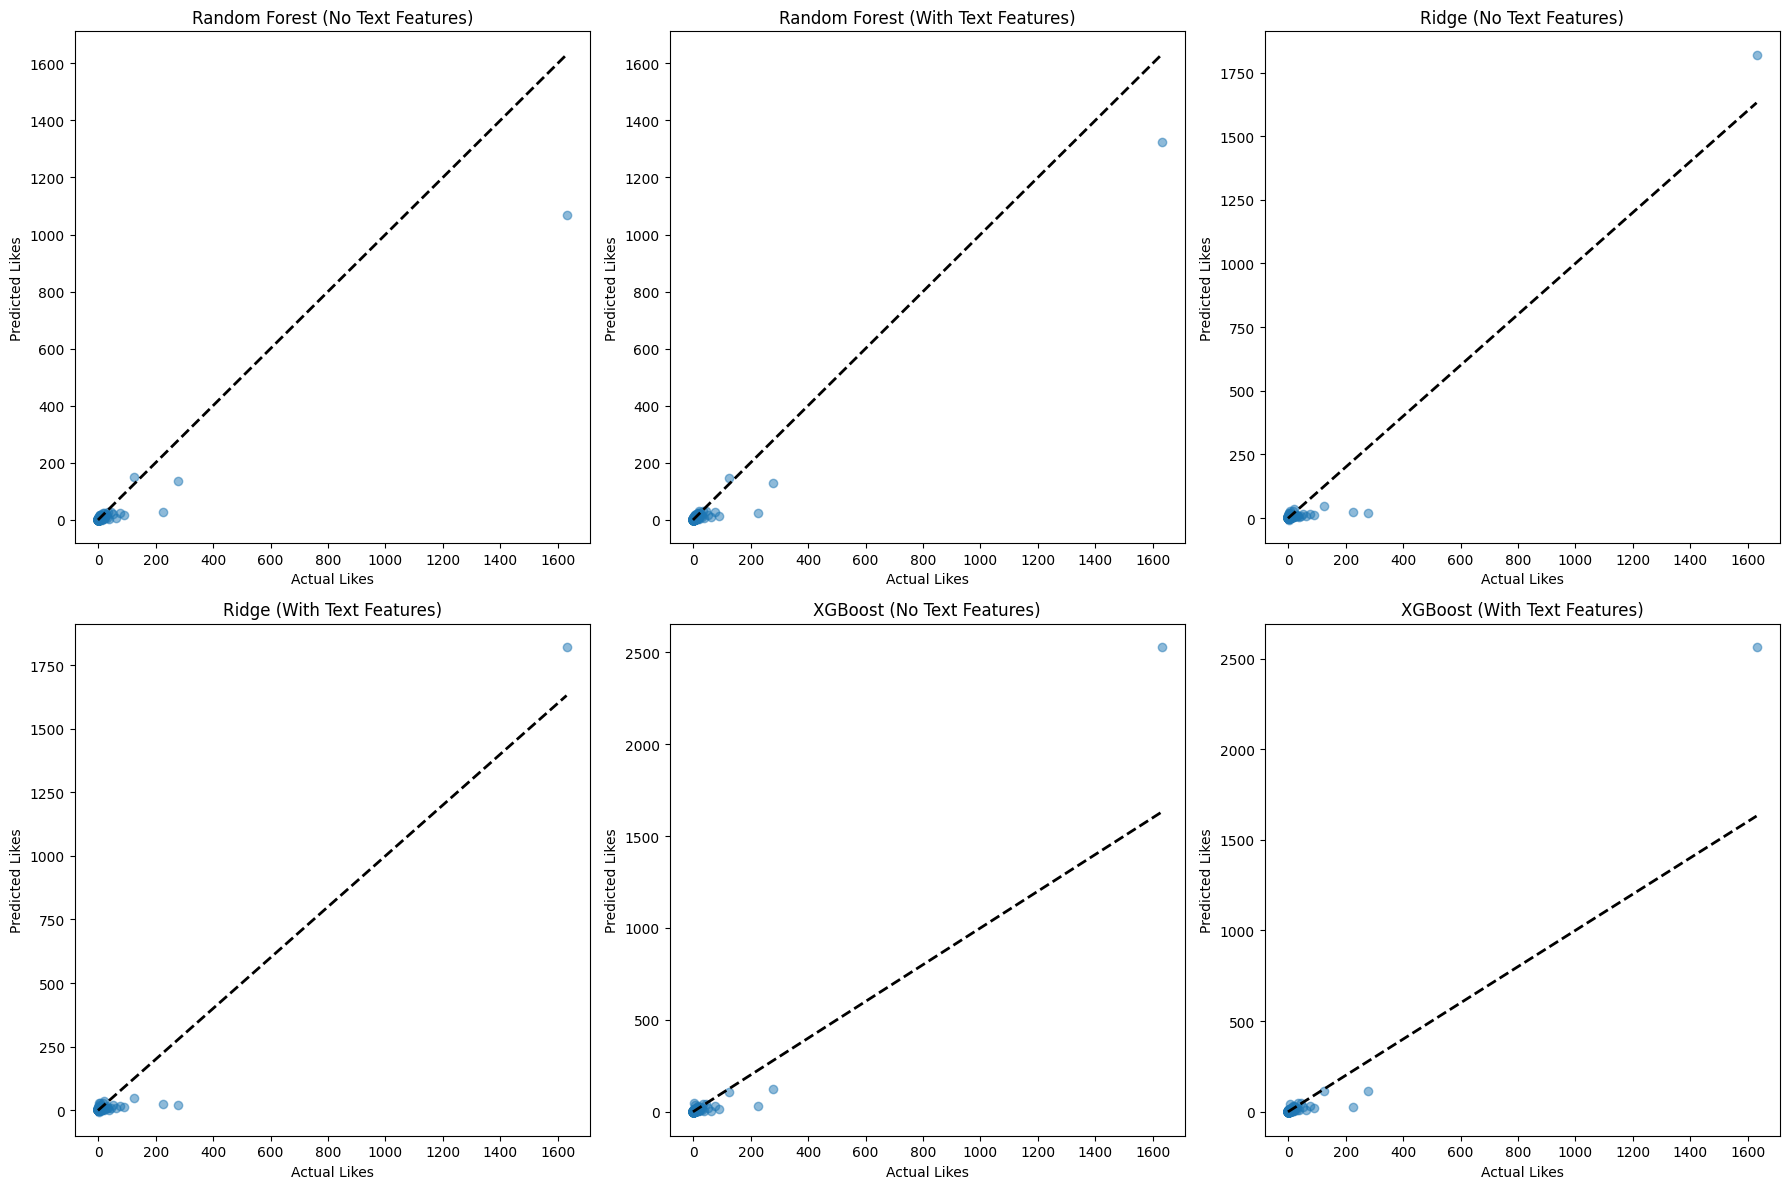

In [ ]:
import matplotlib.pyplot as plt

# Get predictions from each model on the test set
y_pred_rf_no_text = model_no_text.predict(features_test)
y_pred_rf_with_text = model_with_text.predict(features_test_with_text)

y_pred_ridge_no_text = ridge_fit_without_text.predict(features_test)
y_pred_ridge_with_text = ridge_fit_with_text.predict(features_test_with_text)

y_pred_xgb_no_text = xgb_model_no_text.predict(features_test)
y_pred_xgb_with_text = xgb_model_with_text.predict(features_test_with_text)


# Create scatter plots
plt.figure(figsize=(18, 12))

# Random Forest without text
plt.subplot(2, 3, 1)
plt.scatter(target_test, y_pred_rf_no_text, alpha=0.5)
plt.xlabel("Actual Likes")
plt.ylabel("Predicted Likes")
plt.title("Random Forest (No Text Features)")
plt.plot([target_test.min(), target_test.max()], [target_test.min(), target_test.max()], 'k--', lw=2) # Add diagonal line

# Random Forest with text
plt.subplot(2, 3, 2)
plt.scatter(target_test, y_pred_rf_with_text, alpha=0.5)
plt.xlabel("Actual Likes")
plt.ylabel("Predicted Likes")
plt.title("Random Forest (With Text Features)")
plt.plot([target_test.min(), target_test.max()], [target_test.min(), target_test.max()], 'k--', lw=2) # Add diagonal line

# Ridge without text
plt.subplot(2, 3, 3)
plt.scatter(target_test, y_pred_ridge_no_text, alpha=0.5)
plt.xlabel("Actual Likes")
plt.ylabel("Predicted Likes")
plt.title("Ridge (No Text Features)")
plt.plot([target_test.min(), target_test.max()], [target_test.min(), target_test.max()], 'k--', lw=2) # Add diagonal line

# Ridge with text
plt.subplot(2, 3, 4)
plt.scatter(target_test, y_pred_ridge_with_text, alpha=0.5)
plt.xlabel("Actual Likes")
plt.ylabel("Predicted Likes")
plt.title("Ridge (With Text Features)")
plt.plot([target_test.min(), target_test.max()], [target_test.min(), target_test.max()], 'k--', lw=2) # Add diagonal line

# XGBoost without text
plt.subplot(2, 3, 5)
plt.scatter(target_test, y_pred_xgb_no_text, alpha=0.5)
plt.xlabel("Actual Likes")
plt.ylabel("Predicted Likes")
plt.title("XGBoost (No Text Features)")
plt.plot([target_test.min(), target_test.max()], [target_test.min(), target_test.max()], 'k--', lw=2) # Add diagonal line

# XGBoost with text
plt.subplot(2, 3, 6)
plt.scatter(target_test, y_pred_xgb_with_text, alpha=0.5)
plt.xlabel("Actual Likes")
plt.ylabel("Predicted Likes")
plt.title("XGBoost (With Text Features)")
plt.plot([target_test.min(), target_test.max()], [target_test.min(), target_test.max()], 'k--', lw=2) # Add diagonal line

plt.tight_layout()
plt.show()

# User input

In [ ]:
import scipy
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def predict_metrics(model1, model2, encoder, tfidf, df):
    # Define the lists of feature names used during training and the ones to collect from the user
    likes_all_numerical_feature_names = ['Plays','Comments', 'Saves']
    plays_all_numerical_feature_names = ['Likes','Comments', 'Saves', 'Shares']
    #numerical_feature_names_to_collect = ["Duration_(sec)" ] # Only collect Duration (sec) from user
    categorical_feature_names_for_prediction = ["Post_type", "Publish_Date", "Time"] # without genre and content type

    user_input = {}
    print("Please answer the following questions:")

    # Get categorical feature input
    for feature in categorical_feature_names_for_prediction:
        if feature == "Post_type":
            while True:
                user_input[feature] = input(f"What type of post will it be? IG_reel, IG_image, IG_carousel, TikTok_video, or YT_video? ")
                if user_input[feature] in ["IG_reel", "IG_image","IG_carousel", "TikTok_video", "YT_video"]:
                    break
                else:
                    print("Invalid input. Please enter IG_reel, IG_image, IG_carousel, TikTok_video, or YT_video.")
        elif feature == "Publish_Date":
            user_input[feature] = input(f"What when will this post be published? (Use MM/DD/YY format): ")

        elif feature == "Time":
          user_input[feature] = input(f"What time will this post be published? (Use HH:MM:SS format): ")

        else:
            user_input[feature] = input(f"What is the value for {feature}? ")

    # Get Description input for text feature
    user_input['Description'] = input("Please provide a caption / description for the post: ")

    # Get specified numerical feature input
    #for feature in numerical_feature_names_to_collect:
    #    while True:
    #        try:
                # Changed prompt to a question
    #            if feature == "Duration_(sec)":
    #                value = float(input(f"What will be the duration of the post (in seconds)? If the post is an image, enter 0. "))
    #            else:
    #                 value = float(input(f"What is the value for {feature}? "))
    #            user_input[feature] = value
    #            break
    #        except ValueError:
    #            print("Invalid input. Please enter a numerical value.")

    # Create a DataFrame from user input, including all numerical features
    user_df = pd.DataFrame([user_input])

    # Calculate conditional means for numerical features based on 'Post_type'
    post_type = user_input.get('Post_type', 'Unknown')
    df_filtered_by_post_type = df[df['Post_type'] == post_type]

    likes_numerical_means = df_filtered_by_post_type[likes_all_numerical_feature_names].mean().to_dict()
    plays_numerical_means = df_filtered_by_post_type[plays_all_numerical_feature_names].mean().to_dict()


    # Fill in means for numerical features not collected from the user for Likes prediction
    for feature in likes_all_numerical_feature_names:
        if feature not in user_df.columns:
            user_df[feature] = likes_numerical_means.get(feature, df[feature].mean()) # Use overall mean as fallback

    # Process categorical features using the fitted encoder
    user_categorical_features = encoder.transform(user_df[categorical_feature_names_for_prediction])

    # Process text feature using the fitted TF-IDF vectorizer
    user_tfidf_matrix = tfidf.transform(user_df['Description'])

    # Combine all features for Likes prediction
    # Ensure the order of numerical features matches the training data
    user_numerical_features_likes_sparse = scipy.sparse.csr_matrix(user_df[likes_all_numerical_feature_names].values)
    user_features_likes = scipy.sparse.hstack((user_numerical_features_likes_sparse, user_categorical_features), format='csr')
    user_features_with_text_likes = scipy.sparse.hstack((user_features_likes, user_tfidf_matrix), format='csr')

    # Predict Likes
    predicted_likes = model1.predict(user_features_with_text_likes)


    # Predict Plays
    if user_input["Post_type"] == "IG_image":
        predicted_plays = None
    elif user_input["Post_type"] == "IG_carousel":
        predicted_plays = None
    else:
        # For Plays prediction, use Plays specific numerical features
        # Ensure all required numerical columns for Plays prediction are in user_df, fill with means if not provided by user
        for feature in plays_all_numerical_feature_names:
            if feature not in user_df.columns:
                 user_df[feature] = plays_numerical_means.get(feature, df[feature].mean()) # Use overall mean as fallback

        user_numerical_features_plays_sparse = scipy.sparse.csr_matrix(user_df[plays_all_numerical_feature_names].values)
        user_features_plays = scipy.sparse.hstack((user_numerical_features_plays_sparse, user_categorical_features), format='csr')
        user_features_with_text_plays = scipy.sparse.hstack((user_features_plays, user_tfidf_matrix), format='csr')
        predicted_plays = model2.predict(user_features_with_text_plays)

    # Find similar descriptions
    user_description_tfidf = tfidf.transform([user_input['Description']])
    similarity_scores = cosine_similarity(user_description_tfidf, tfidf_matrix)
    similar_indices = similarity_scores.argsort()[0][::-1][1:6] # Get top 5 most similar (excluding the input itself)
    similar_posts = df.iloc[similar_indices][['Description', 'Permalink', 'Post_type', 'Likes', 'Plays']] # Display relevant columns

    return predicted_likes[0], predicted_plays[0] if predicted_plays is not None else None, similar_posts # Return both predictions and similar posts


while True:
    estimated_likes, estimated_plays, similar_posts = predict_metrics(
        #xgb_model_with_text,
        model_with_text,
        #Plays_xgb_model_with_text,
        Plays_ridge_fit_with_text,
        encoder,
        tfidf,
        df
    )
    print(f"\nEstimated Likes: {estimated_likes:.2f}")
    print(f"\nRounded Likes:  {round(estimated_likes):.2f}")
    if estimated_plays is not None:
        print(f"\nEstimated Plays: {estimated_plays:.2f}")
        print(f"\nRounded Plays:  {round(estimated_plays):.2f}")
    else:
        print("\nEstimated Plays: None")

    print("\n--- Posts with Similar Descriptions ---")
    display(similar_posts)
    print("-" * 30)


    another_prediction = input(f"\nDo you want to make another prediction? (yes/no): ").lower()
    if another_prediction != 'yes':
        break

Please answer the following questions:
What type of post will it be? IG_reel, IG_image, IG_carousel, TikTok_video, or YT_video? IG_reel
What when will this post be published? (Use MM/DD/YY format): 09/17/25
What time will this post be published? (Use HH:MM:SS format): 13:35:00
Please provide a caption / description for the post: Find your Zenitsu who will help you better with his screams of encouragement. #demonslayer #tanjirokamado #inosuke #hashibatrainingarc #motivation #anime #manga #tv #fyp #viral #trendy #cooledtured #podcast #gamer #humor #hollywood #funny #comedy

Estimated Likes: 3.74

Rounded Likes:  4.00

Estimated Plays: 350.49

Rounded Plays:  350.00

--- Posts with Similar Descriptions ---


,Description,Permalink,Post_type,Likes,Plays
797,Inosuke beats Zenitsu where it hurts the most ...,https://www.instagram.com/reel/C3v4wbavSnG/,IG_reel,212,4291.0
1657,#pokemon #pokemontcg #comedy #funny #joke #cos...,uHOfYd_JSR8,YT_video,5,405.0
1663,#pokemon #pokémontcg #prismaticevolutions #eev...,VEqY7fL3kSs,YT_video,5,409.0
1299,I think it all went wrong\n#nintendo #viral #h...,https://www.instagram.com/reel/DKxsmLIPk_8/,IG_reel,2,159.0
847,Can you answer these trivia questions? #tengen...,https://www.instagram.com/reel/C5A_WBKrpMW/,IG_reel,4,177.0


------------------------------

Do you want to make another prediction? (yes/no): no


# XGBoost model combinations

In [ ]:
from itertools import combinations

independent_variables = ["Duration_(sec)", "Reach", "Shares", "Plays", "Comments", "Saves", "Hour", "Month", "Day_of_Week", "Post_type", "Description"]

all_possible_combinations = []
for r in range(1, len(independent_variables) + 1):
    all_possible_combinations.extend(list(combinations(independent_variables, r)))

In [ ]:
import xgboost as xgb
import scipy
import numpy as np

xgboost_models = {}

for combo in all_possible_combinations:
    feature_list = []
    combo_without_special = [f for f in combo if f != "Post_type" and f != "Description"]

    if combo_without_special:
        # Ensure numerical features are treated as a 2D array and converted to a sparse matrix
        numerical_features_subset = df[list(combo_without_special)].values
        if numerical_features_subset.ndim == 1:
             numerical_features_subset = numerical_features_subset.reshape(-1, 1)
        feature_list.append(scipy.sparse.csr_matrix(numerical_features_subset))


    if "Post_type" in combo:
        feature_list.append(one_hot_features)

    if "Description" in combo:
        feature_list.append(tfidf_matrix)

    if not feature_list: # Skip if no features are selected
        continue

    X = scipy.sparse.hstack(feature_list, format='csr')

    y = df['Likes']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=rand_seed)

    xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=12)
    xgb_model.fit(X_train, y_train)

    xgboost_models[tuple(combo)] = xgb_model

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error
import scipy
import numpy as np

xgboost_results = {}

for combo, model in xgboost_models.items():
    # Reconstruct the test features using the same logic as training
    feature_list_test = []
    combo_without_special_test = [f for f in combo if f != "Post_type" and f != "Description"]

    if combo_without_special_test:
        numerical_features_subset_test = df.loc[features_test.nonzero()[0], list(combo_without_special_test)].values
        if numerical_features_subset_test.ndim == 1:
            numerical_features_subset_test = numerical_features_subset_test.reshape(-1, 1)
        feature_list_test.append(scipy.sparse.csr_matrix(numerical_features_subset_test))

    if "Post_type" in combo:
        # Select the corresponding rows from one_hot_features for the test set
        test_indices = features_test.nonzero()[0]
        feature_list_test.append(one_hot_features[test_indices])

    if "Description" in combo:
        # Select the corresponding rows from tfidf_matrix for the test set
        test_indices = features_test.nonzero()[0]
        feature_list_test.append(tfidf_matrix[test_indices])

    if not feature_list_test: # Should not happen if combo is not empty, but as a safeguard
        continue

    X_test_processed = scipy.sparse.hstack(feature_list_test, format='csr')


    y_test = df.loc[features_test.nonzero()[0], 'Likes'] # Select corresponding Likes for test set

    y_pred = model.predict(X_test_processed)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    xgboost_results[combo] = {'R-squared': r2, 'RMSE': rmse}

#print the results
#for combo, metrics in xgboost_results.items():
    #print(f"Features: {combo}, R-squared: {metrics['R-squared']:.3f}, RMSE: {metrics['RMSE']:.3f}")

In [ ]:
# Sort results by R-squared in descending order
sorted_results = sorted(xgboost_results.items(), key=lambda item: item[1]['R-squared'], reverse=True)

print("--- XGBoost Model Evaluation Results (Sorted by R-squared) ---")

# Iterate through sorted results and print them
for combo, metrics in sorted_results:
    print(f"Features: {combo}, R-squared: {metrics['R-squared']:.3f}, RMSE: {metrics['RMSE']:.3f}")

print("-" * 60)

--- XGBoost Model Evaluation Results (Sorted by R-squared) ---
Features: ('Duration_(sec)', 'Reach', 'Saves', 'Hour', 'Month', 'Day_of_Week', 'Post_type'), R-squared: 0.998, RMSE: 6.812
Features: ('Duration_(sec)', 'Reach', 'Shares', 'Plays', 'Saves', 'Hour', 'Month', 'Post_type'), R-squared: 0.998, RMSE: 7.022
Features: ('Reach', 'Plays', 'Saves', 'Month', 'Day_of_Week', 'Post_type'), R-squared: 0.998, RMSE: 7.204
Features: ('Duration_(sec)', 'Shares', 'Plays', 'Saves', 'Month', 'Post_type'), R-squared: 0.998, RMSE: 7.302
Features: ('Duration_(sec)', 'Plays', 'Saves', 'Month', 'Post_type'), R-squared: 0.998, RMSE: 7.314
Features: ('Reach', 'Shares', 'Plays', 'Saves', 'Hour', 'Month', 'Day_of_Week', 'Post_type'), R-squared: 0.998, RMSE: 7.584
Features: ('Duration_(sec)', 'Reach', 'Saves', 'Hour', 'Day_of_Week'), R-squared: 0.998, RMSE: 7.600
Features: ('Reach', 'Plays', 'Saves', 'Post_type'), R-squared: 0.998, RMSE: 7.639
Features: ('Duration_(sec)', 'Reach', 'Shares', 'Plays', 'Saves'

In [ ]:
print("--- XGBoost Model Evaluation Results (Combinations with Post_type and Description) ---")

for combo, metrics in sorted_results:
    if "Post_type" in combo and "Description" in combo:
        print(f"Features: {combo}, R-squared: {metrics['R-squared']:.3f}, RMSE: {metrics['RMSE']:.3f}")

print("-" * 60)

--- XGBoost Model Evaluation Results (Combinations with Post_type and Description) ---
Features: ('Duration_(sec)', 'Reach', 'Plays', 'Comments', 'Saves', 'Month', 'Day_of_Week', 'Post_type', 'Description'), R-squared: 0.995, RMSE: 10.602
Features: ('Reach', 'Plays', 'Comments', 'Saves', 'Month', 'Post_type', 'Description'), R-squared: 0.995, RMSE: 10.605
Features: ('Duration_(sec)', 'Reach', 'Plays', 'Comments', 'Saves', 'Month', 'Post_type', 'Description'), R-squared: 0.995, RMSE: 10.659
Features: ('Duration_(sec)', 'Reach', 'Plays', 'Comments', 'Saves', 'Day_of_Week', 'Post_type', 'Description'), R-squared: 0.995, RMSE: 10.779
Features: ('Reach', 'Plays', 'Comments', 'Saves', 'Post_type', 'Description'), R-squared: 0.995, RMSE: 10.805
Features: ('Reach', 'Plays', 'Comments', 'Saves', 'Month', 'Day_of_Week', 'Post_type', 'Description'), R-squared: 0.995, RMSE: 10.875
Features: ('Duration_(sec)', 'Reach', 'Plays', 'Comments', 'Saves', 'Post_type', 'Description'), R-squared: 0.995, RMS

# Gradio app

In [ ]:
!pip install --upgrade gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.3/60.3 MB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.0/325.0 kB 25.6 MB/s eta 0:00:00
  Attempting uninstall: gradio-client
    Found existing installation: gradio_client 1.12.1
    Uninstalling gradio_client-1.12.1:
      Successfully uninstalled gradio_client-1.12.1
  Attempting uninstall: gradio
    Found existing installation: gradio 5.44.1
    Uninstalling gradio-5.44.1:
      Successfully uninstalled gradio-5.44.1


In [ ]:
import scipy
import numpy as np
import gradio as gr
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

# Assuming df, encoder, tfidf, model_with_text, and Plays_ridge_fit_with_text are already defined

def predict_metrics_interface(post_type, publish_date, time, description):
    # Recreate the user_input dictionary from the Gradio inputs
    user_input = {
        "Post_type": post_type,
        "Publish_Date": publish_date,
        "Time": time,
        "Description": description
    }

    # Define the lists of feature names used during training
    likes_all_numerical_feature_names = ['Plays','Comments', 'Saves']
    plays_all_numerical_feature_names = ['Likes','Comments', 'Saves', 'Shares']
    categorical_feature_names_for_prediction = ["Post_type", "Publish_Date", "Time"]

    # Create a DataFrame from user input
    user_df = pd.DataFrame([user_input])

    # Calculate conditional means for numerical features based on 'Post_type'
    post_type = user_input.get('Post_type', 'Unknown')
    df_filtered_by_post_type = df[df['Post_type'] == post_type]

    likes_numerical_means = df_filtered_by_post_type[likes_all_numerical_feature_names].mean().to_dict()
    plays_numerical_means = df_filtered_by_post_type[plays_all_numerical_feature_names].mean().to_dict()

    # Fill in means for numerical features not collected from the user for Likes prediction
    for feature in likes_all_numerical_feature_names:
        if feature not in user_df.columns:
            user_df[feature] = likes_numerical_means.get(feature, df[feature].mean()) # Use overall mean as fallback

    # Process categorical features using the fitted encoder
    user_categorical_features = encoder.transform(user_df[categorical_feature_names_for_prediction])

    # Process text feature using the fitted TF-IDF vectorizer
    user_tfidf_matrix = tfidf.transform(user_df['Description'])

    # Combine all features for Likes prediction
    user_numerical_features_likes_sparse = scipy.sparse.csr_matrix(user_df[likes_all_numerical_feature_names].values)
    user_features_likes = scipy.sparse.hstack((user_numerical_features_likes_sparse, user_categorical_features), format='csr')
    user_features_with_text_likes = scipy.sparse.hstack((user_features_likes, user_tfidf_matrix), format='csr')

    # Predict Likes
    predicted_likes = model_with_text.predict(user_features_with_text_likes)


    # Predict Plays
    if user_input["Post_type"] == "IG_image" or user_input["Post_type"] == "IG_carousel":
        predicted_plays = "N/A for this post type"
    else:
        # For Plays prediction, use Plays specific numerical features
        for feature in plays_all_numerical_feature_names:
            if feature not in user_df.columns:
                 user_df[feature] = plays_numerical_means.get(feature, df[feature].mean()) # Use overall mean as fallback

        user_numerical_features_plays_sparse = scipy.sparse.csr_matrix(user_df[plays_all_numerical_feature_names].values)
        user_features_plays = scipy.sparse.hstack((user_numerical_features_plays_sparse, user_categorical_features), format='csr')
        user_features_with_text_plays = scipy.sparse.hstack((user_features_plays, user_tfidf_matrix), format='csr')
        predicted_plays = Plays_ridge_fit_with_text.predict(user_features_with_text_plays)[0]
        predicted_plays = f"{predicted_plays:.2f}" # Format to 2 decimal places


    # Find similar descriptions
    user_description_tfidf = tfidf.transform([user_input['Description']])
    similarity_scores = cosine_similarity(user_description_tfidf, tfidf_matrix)
    similar_indices = similarity_scores.argsort()[0][::-1][1:6] # Get top 5 most similar (excluding the input itself)
    similar_posts = df.iloc[similar_indices][['Description', 'Permalink', 'Post_type', 'Likes', 'Plays']] # Display relevant columns

    # Format the output for Gradio
    similar_posts_str = similar_posts.to_string(index=False)
    output_text = f"Estimated Likes: {predicted_likes[0]:.2f}\nRounded Likes: {round(predicted_likes[0]):.2f}\n\nEstimated Plays: {predicted_plays}\nRounded Likes: {round(predicted_plays[0]):.2f}\n\n--- Posts with Similar Descriptions ---\n{similar_posts_str}"

    return output_text

# Define the Gradio Interface
demo = gr.Interface(
    fn=predict_metrics_interface,
    inputs=[
        gr.Dropdown(["IG_reel", "IG_image", "IG_carousel", "TikTok_video", "YT_video"], label="Post Type"),
        gr.Textbox(label="Publish Date (MM/DD/YY)"),
        gr.Textbox(label="Time (HH:MM:SS)"),
        gr.Textbox(label="Caption / Description")
    ],
    outputs= gr.Textbox(label="Output", lines=10),
    title="Social Media Post Performance Predictor",
    description="Enter details about your social media post to predict likes and plays."
)

# Launch the Gradio app
if __name__ == "__main__":
    demo.launch(debug=True)

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://cd5c9e0fb614d7418d.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/gradio/queueing.py", line 667, in process_events
    response = await route_utils.call_process_api(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/gradio/route_utils.py", line 349, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/gradio/blocks.py", line 2274, in process_api
    result = await self.call_function(
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/gradio/blocks.py", line 1781, in call_function
    prediction = await anyio.to_thread.run_sync(  # type: ignore
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/anyio/to_thread.py", line 56, in run_sync
    return await get_async_backend().run_sync_in_worker_thread(
           ^^^^^

Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://cd5c9e0fb614d7418d.gradio.live


# Dash app

In [11]:
pip install dash


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 47.3 MB/s eta 0:00:00


In [13]:
!pip install dash-bootstrap-components

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.0/204.0 kB 5.0 MB/s eta 0:00:00


In [16]:
#!pip freeze > requirements.txt
from dash import Dash, dcc, html, Input, Output, State
import dash_bootstrap_components as dbc # Using Bootstrap components for better styling

# Initialize the Dash app
app = Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

# Define the app layout
app.layout = dbc.Container([
    html.H1("Social Media Post Performance Predictor", className="text-center my-4"),

    dbc.Row([
        dbc.Col(dbc.Label("Post Type:"), width=3),
        dbc.Col(dcc.Dropdown(
            id='post-type-dropdown',
            options=[
                {'label': 'IG Reel', 'value': 'IG_reel'},
                {'label': 'IG Image', 'value': 'IG_image'},
                {'label': 'IG Carousel', 'value': 'IG_carousel'},
                {'label': 'TikTok Video', 'value': 'TikTok_video'},
                {'label': 'YT Video', 'value': 'YT_video'}
            ],
            value='IG_reel', # default value
            clearable=False
        ), width=9),
    ], className="mb-3"),

    dbc.Row([
        dbc.Col(dbc.Label("Publish Date (MM/DD/YY):"), width=3),
        dbc.Col(dbc.Input(id='publish-date-input', type='text', placeholder='MM/DD/YY'), width=9),
    ], className="mb-3"),

    dbc.Row([
        dbc.Col(dbc.Label("Time (HH:MM:SS):"), width=3),
        dbc.Col(dbc.Input(id='time-input', type='text', placeholder='HH:MM:SS'), width=9),
    ], className="mb-3"),

    dbc.Row([
        dbc.Col(dbc.Label("Caption / Description:"), width=3),
        dbc.Col(dbc.Textarea(id='description-input', placeholder='Enter post caption/description', rows=4), width=9),
    ], className="mb-3"),

    dbc.Row([
        dbc.Col(dbc.Button("Predict", id="predict-button", className="me-2", n_clicks=0), width={"size": 6, "offset": 3}),
    ], className="mb-3 text-center"),

    dbc.Row([
        dbc.Col(dbc.Card(
            dbc.CardBody([
                html.H4("Prediction Results", className="card-title"),
                html.Div(id='prediction-output')
            ])
        ), width=12)
    ])
])

# Define the callback function
@app.callback(
    Output('prediction-output', 'children'),
    [Input('predict-button', 'n_clicks')],
    [State('post-type-dropdown', 'value'),
     State('publish-date-input', 'value'),
     State('time-input', 'value'),
     State('description-input', 'value')]
)
def update_output(n_clicks, post_type, publish_date, time, description):
    if n_clicks > 0:
        try:
            estimated_likes, estimated_plays, similar_posts = predict_metrics(
                post_type, publish_date, time, description
            )

            output_text = [
                html.P(f"Estimated Likes: {estimated_likes:.2f}"),
                html.P(f"Rounded Likes: {round(estimated_likes):.2f}"),
                html.Br()
            ]

            if estimated_plays is not None:
                 output_text.extend([
                     html.P(f"Estimated Plays: {estimated_plays:.2f}"),
                     html.P(f"Rounded Plays: {round(estimated_plays):.2f}"),
                     html.Br()
                 ])
            else:
                 output_text.append(html.P("Estimated Plays: N/A for this post type"))

            output_text.append(html.P("--- Posts with Similar Descriptions ---"))
            similar_posts_table = dbc.Table.from_dataframe(similar_posts, striped=True, bordered=True, hover=True)
            output_text.append(similar_posts_table)

            return output_text

        except Exception as e:
            return html.P(f"Error: {e}", style={'color': 'red'})
    return "Enter post details and click Predict" # Initial message

# Run the app
if __name__ == '__main__':
    app.run(debug=True, mode='inline')

#server = app.server

<IPython.core.display.Javascript object>

In [17]:
!pip freeze > requirements.txt